For installing torchsummary use `pip install torchsummary`

In [1]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt

## Multinomial Classification of MNIST 

1. Load the MNIST dataset by clicking through the first cells and see how to depict some samples. Please note that a training and a test dataset are loaded. Make sure that only the training set will be used for training and the test dataset just for evaluation (accuracy). 
2. Implement the multinomial logistic regression model by completing the code in the functions \verb|linear_trsf|, \verb|softmax|, \verb|predict|, \verb|loss_ce|, \verb|cost_ce|. 
3. Implement the mini-batch gradient descent training loop configured by number of epochs, batch size and learning rate. Implement the gradient explicitly (without autograd). Train the model with \verb|nepochs=10|, \verb|nbatch=64| and \verb|lr=0.01|. 
4. Tune learning rate and batch size and qualitatively characterise the behaviour. What is your favorite combination (learning rate, batch size, number of epochs)
5. Build and train the model with full-fledge pytorch incl. autograd. Implement a model class inheriting from $torch.nn.Module$ and use the layer functionality in the package $torch.nn$ (see lecture). Prove that you obtain the same accuracy.


#### Hints 
* Keep an eye on the shapes of the tensors (as passed into the functions and as used within the functions (and declared in the function descriptions).
* For each implemented function, run a small test with dummy input tensors (of the required shape) and check whether it outputs a tensor with expected shape and no 'nan'.
* Possibly, add \verb|assert()| statements in the code.
* For the training loop perform a training with only a single batch of size 64. Here, you should be able to obtain 100% training accuracy.

### 1. Loading the Data

Click through the cells below to load the MNIST dataset and learn how to access its samples.

#### Dataset

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


In [4]:
print(len(training_data))
x, y = training_data[5]
print(type(x), x.shape, x.dtype)
print(type(y), y)

60000
<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32
<class 'int'> 2


#### Depict samples

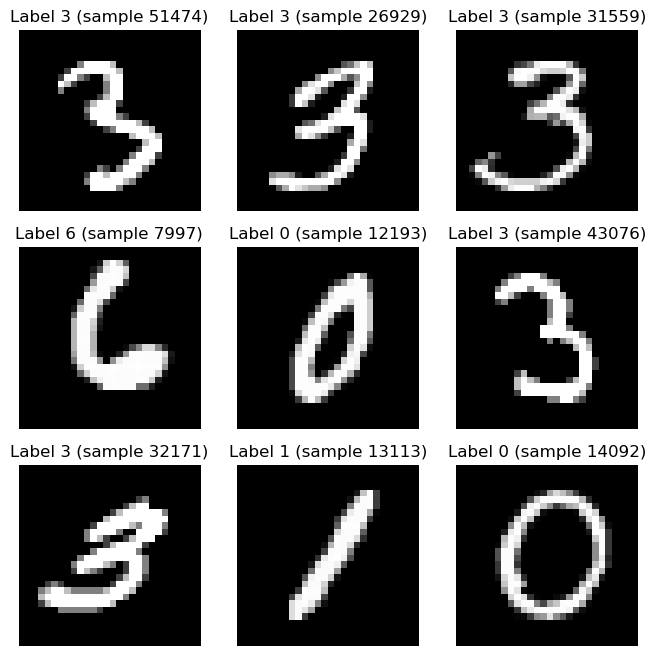

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)"%(label,sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader (see lecture)

In [6]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [7]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


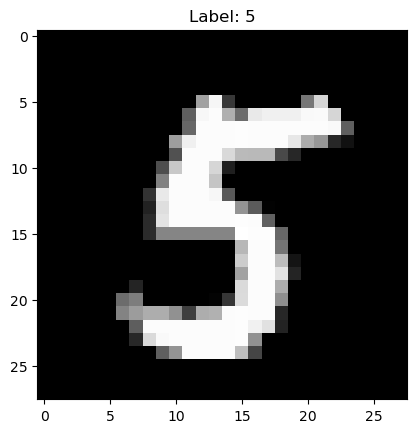

In [8]:
img = data_train[0].squeeze()
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### 2. Multinomial Logistic Regression

Now, implement the model, i.e. multinomial logistic regression and the loss/cost function (cross-entropy cost).

To that end, implement the python functions below. 
All arguments are pytorch tensors with indicated shapes.

In [9]:
def linear_trsf(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    # W^T has dimensions 28x28,10 => Reshape X:
    # Reshape x to be of dim(nb*1,28X28)
    N = x.shape[0] # batch size
    x1 = x.view(N, -1) #flatten image
    return x1@W.T+b
    # YOUR CODE (END)

def softmax(z):
    """
    z -- tensor of shape (nb,10)
    """
    # YOUR CODE (START) (nb,10) / (1,10) without reshape:
    s = torch.exp(z)
    return s/torch.sum(s, dim=1).reshape(-1,1)
    # YOUR CODE (END)
    
def predict(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START) Probability of each class is returned:
    return softmax(linear_trsf(x,W,b))
    # YOUR CODE (END)


##### TEST

In [10]:
W,b = torch.randn((10,28*28)), torch.zeros((1,10))
print(W.shape, b.shape)
u = predict(x,W,b)
# Probability should add up to one
print(u.shape, torch.sum(u).item())

torch.Size([10, 784]) torch.Size([1, 10])
torch.Size([1, 10]) 1.0


#### Loss Function

In [11]:
def loss_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    returns -- per sample loss 
    """
    # Get the one-hot encoded vecotor:
    # one_hot = torch.nn.functional.one_hot(y, num_classes=uhat.shape[1])
    # return -torch.sum(y_onehot * torch.log(uhat), dim=1)
    N = y.shape[0]
    return -torch.log(uhat[torch.arange(N), y[:]])

    
    # YOUR CODE (END)

def cost_ce(y,uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    return -- per batch mean of losses
    """
    # YOUR CODE (START)    
    return torch.mean(loss_ce(y,uhat))
    # YOUR CODE (END)


##### TEST

In [12]:
import numpy as np
y = torch.tensor([0,2])
z = torch.tensor([[1.,2,3],[2,2,2]]).reshape(-1,3)
uhat = softmax(z)
print(loss_ce(y,uhat), cost_ce(y,uhat))

tensor([2.4076, 1.0986]) tensor(1.7531)


### 3. Mini-Batch Gradient Descent

For the training, we adopt gradient descent - and start with the implementation of the gradient of the cost function (cross-entropy cost function).  

#### Gradient

$\frac{\partial L_{\mathrm{CE}}}{\partial W_{i j}}=\underset{\begin{array}{c}
\text { averaged } \\
\text { over samples }
\end{array}}{\left(s_i-u_i\right) x_j}$

In [13]:
def grad_loss_ce(X,u,uhat):
    """
    x -- tensor with shape (nb,1, 28*28)
    u -- tensor with shape (nb,10)
    uhat -- tensor with shape (nb,10)
    returns -- gradW, gradb (same dimension as W and b)
    """
    # YOUR CODE (START)
    grad_W = torch.mean((uhat-u).view(-1,10,1)*X.view(-1,1,28*28), dim=0)
    grad_b = torch.mean((uhat-u), dim=0)
    return grad_W, grad_b     
    # YOUR CODE (END)

#### Metrics - Cost, Accuracy

For tracking the progress of the training, we will use two functions: the cost and the accuracy. 

In [14]:
def metrics(X,Y,W,b):
    """
    X -- tensor with shape (nb,1,28*28)
    Y -- tensor with shape (nb,10)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (10,1)
    
    return -- cost, acc (both scalars)
    """
    # YOUR CODE (START) 
    predictions = predict(X,W,b)
    pre_class = torch.argmax(predictions, dim=1)
    cost = cost_ce(Y,predictions)
    accs  = torch.sum(pre_class == Y) / len(Y)
    
    return cost,accs
    # YOUR CODE (END)

#### Training

In [15]:
nepochs = 10
alpha = 0.1
nclasses = 10
nbatch = 64
num_batches = len(training_data)/float(nbatch)

cost_hist = []
acc_hist = []
cost_hist_test = []
acc_hist_test = []

# data loader
train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)

# test data - we can load all samples for the test since it easily fits into memory
Xtest,Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True))) 

# initial parameters
W,b = torch.randn((10,28*28)), torch.zeros((1,10))

d0 = datetime.now()

for epoch in range(nepochs):
    cost = 0.0
    cost_test = 0.0
    acc = 0
    acc_test = 0
    
    for X,Y in train_dataloader:
        uhat = predict(X,W,b)
        u = (Y.view(-1,1) == torch.arange(nclasses).view(1, nclasses)).float()
        
        # Gradients and update weights:
        grad_W, grad_b = grad_loss_ce(X=X, u=u, uhat=uhat)
        W = W - alpha * grad_W
        b = b - alpha * grad_b
        
        # Get the metrics:
        cost_batch, acc_batch = metrics(X,Y,W,b)
        
        # Update: 
        cost += cost_batch.item()
        acc += acc_batch.item()
        
    # Average cost and accuracy for each of the epochs:
    cost = cost / num_batches
    acc = acc / num_batches
    
    # Get the metrics for each of the epochs:
    cost_test, acc_test = metrics(Xtest,Ytest,W,b)
    
    # Store results for each epoch:
    cost_hist.append(cost)
    acc_hist.append(acc)
    cost_hist_test.append(cost_test)
    acc_hist_test.append(acc_test)
    
        
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    
d = datetime.now()
print((d-d0).total_seconds()/nepochs)  

Epoch 0: 2.068037, 0.655283, 0.939995, 0.801300
Epoch 1: 0.807924, 0.825550, 0.717994, 0.841100
Epoch 2: 0.665767, 0.852500, 0.629820, 0.859600
Epoch 3: 0.592193, 0.865717, 0.578161, 0.870000
Epoch 4: 0.544361, 0.874900, 0.542178, 0.875700
Epoch 5: 0.510417, 0.880250, 0.513116, 0.880600
Epoch 6: 0.483618, 0.885433, 0.496052, 0.884400
Epoch 7: 0.463560, 0.888833, 0.476252, 0.886400
Epoch 8: 0.446588, 0.891800, 0.464323, 0.890200
Epoch 9: 0.431464, 0.895383, 0.457669, 0.888800
4.6103605000000005


Text(0.5, 1.0, 'Accuracy')

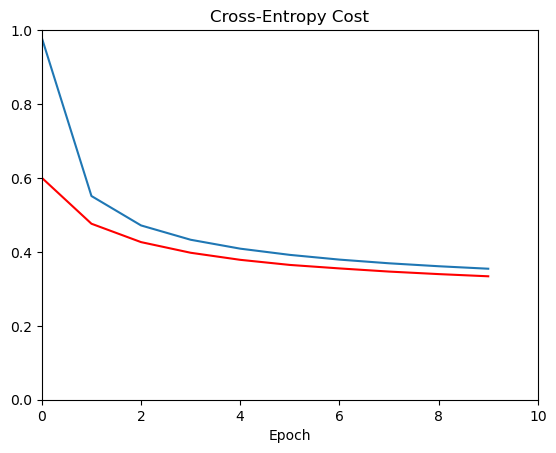

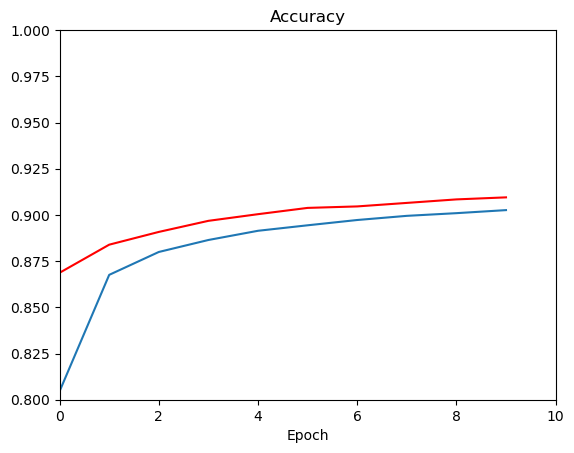

In [33]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")

### 4. Tune learning rate and batch size

Now analyse the training progress with five, well selected settings for each, the learning rate and the batch size.
Make sure that for each setting, a more or less "stable" test performance is achieved, i.e. a status where the test accurace is no longer expected to improve. Choose the number of epochs accordingly.

Finally, prepare suitable plots and tables to make the comparison transparent and characterize in words what you observe. 

Explain the behavior.

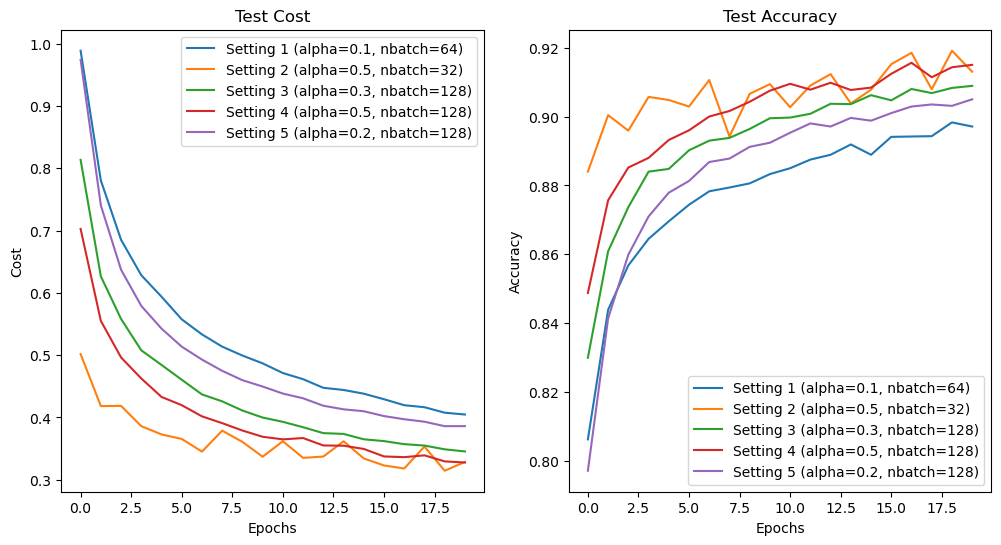

In [20]:
def train(alpha,nepochs,nbatch):
    nclasses = 10
    num_batches = len(training_data)/float(nbatch)
    cost_hist = []
    acc_hist = []
    cost_hist_test = []
    acc_hist_test = []
    train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    Xtest,Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True))) 
    W,b = torch.randn((10,28*28)), torch.zeros((1,10))
    d0 = datetime.now()
    for epoch in range(nepochs):
        cost_test = 0.0
        acc_test = 0
        for X,Y in train_dataloader:
            uhat = predict(X,W,b)
            u = (Y.view(-1,1) == torch.arange(nclasses).view(1, nclasses)).float()
            grad_W, grad_b = grad_loss_ce(X=X, u=u, uhat=uhat)
            W = W - alpha * grad_W
            b = b - alpha * grad_b
            cost_batch, acc_batch = metrics(X,Y,W,b)
        cost_test, acc_test = metrics(Xtest,Ytest,W,b)
        cost_hist_test.append(cost_test)
        acc_hist_test.append(acc_test)
        
    return cost_hist_test, acc_hist_test
        
# lr, epoch, batch_size:
models = {
    1: [0.1, 20, 64],
    2: [0.5, 20, 32],
    3: [0.3, 20, 128],
    4: [0.5, 20, 128],
    5: [0.2, 20, 128]
}
          
# Plotting test cost and test accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for setting, (learning_rate, epochs, batch_size) in models.items():
    cost_hist_test, acc_hist_test = train(learning_rate, epochs, batch_size)
    
    ax1.plot(cost_hist_test, label=f"Setting {setting} (alpha={learning_rate}, nbatch={batch_size})")
    ax2.plot(acc_hist_test, label=f"Setting {setting} (alpha={learning_rate}, nbatch={batch_size})")

ax1.set_title("Test Cost")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cost")
ax1.legend()

ax2.set_title("Test Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

**Best Model**: learning_rate = 0.5, batch_size=32

**Some overvations:**
1Regarding the batch size: We can get ***wiggly*** lines due to variying composition of the mini batches and initalisation of weights. Smaller batches can also lead to noisier gradients, as we can see in the orange line. Due to the largest learning rate alpha=0.5 the orange line takes larger steps compared to the other lines. As 32 is a smaller batches help us not get trapped in **sharp narrow minimas**.

As we only use 20 epochs in my example it has to be noted, that a larger learning rate may be more benefical. This is due to the fact that a small learning rate may converge smoother, however requires a larger amount of epochs to do so. This could be the reason, why the orange line is performing the best.


# 5. With Full-Fledge PyTorch

In [24]:
class NeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear  = torch.nn.Linear(28*28,10)
    
    def forward(self, x): # use just one linear layer and pytorch's CrossEntropyLoss
        z = self.linear(self.flatten(x))
        return z


In [25]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [26]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [32]:
nbatch = 64
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

model = NeuralNetwork()
cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
Xtest, Ytest = next(iter(test_loader))
size = len(training_loader.dataset)
nbatches = len(training_loader)

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
       
        # Forward Pass
        pred = model(X)
        
        # Calculate loss and accuraccy:
        loss = cost_ce(pred,Y)
        cost += loss.item()
        acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

        
        # gradient, parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    cost /= nbatches
    acc /= size
    
    cost_test = 0.0
    acc_test = 0.0
    with torch.no_grad():
        for X,Y in test_loader:
            pred = model(X)
            loss = cost_ce(pred,Y)
            cost_test += loss.item()
            acc_test += (pred.argmax(dim=1)==Y).type(torch.float).sum().item()
    
    cost_test /= len(test_loader)
    acc_test  /= len(test_loader.dataset)   
    
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 0.978932, 0.804600, 0.600367, 0.868700
Epoch 1: 0.551163, 0.867567, 0.476186, 0.883900
Epoch 2: 0.471567, 0.879950, 0.426437, 0.890800
Epoch 3: 0.432813, 0.886433, 0.397624, 0.896800
Epoch 4: 0.408700, 0.891417, 0.378502, 0.900400
Epoch 5: 0.391889, 0.894383, 0.364697, 0.903800
Epoch 6: 0.379075, 0.897250, 0.355255, 0.904600
Epoch 7: 0.369129, 0.899500, 0.346720, 0.906500
Epoch 8: 0.361156, 0.900950, 0.339888, 0.908400
Epoch 9: 0.354434, 0.902600, 0.333955, 0.909500


Text(0.5, 1.0, 'Accuracy')

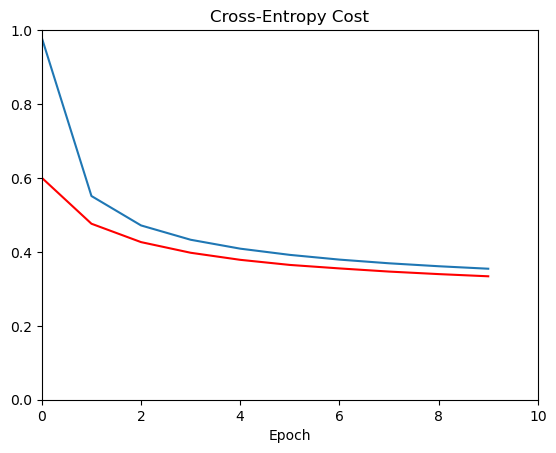

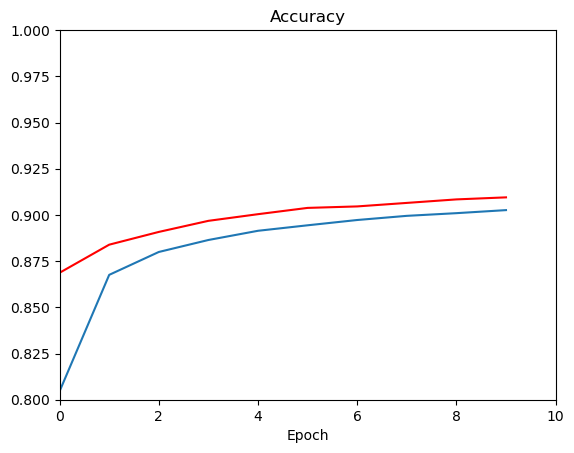

In [34]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")